The paper we are replicating here is : [N-BEATS: NEURAL BASIS EXPANSION ANALYSIS FOR
INTERPRETABLE TIME SERIES FORECASTING](https://arxiv.org/pdf/1905.10437)

<img src="model.png" width=50% style="display: block; margin-left: auto; margin-right: auto;">

### 

### Preprocess the data

In [9]:
import pandas as pd
df = pd.read_csv('data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [11]:
len(df), df.shape, df.size

(2787, (2787, 5), 13935)

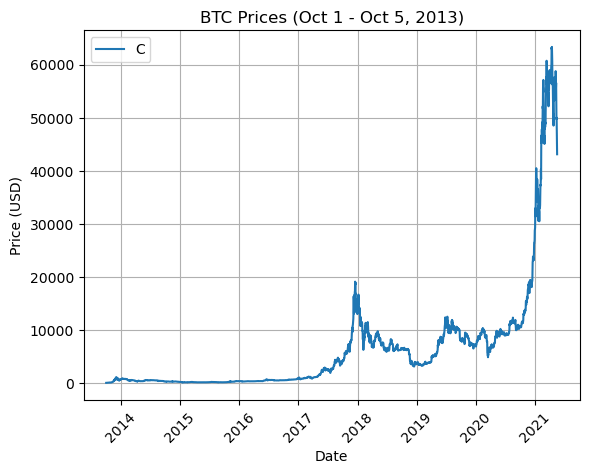

In [12]:
import matplotlib.pyplot as plt

plt.plot(df.index, df["Closing Price (USD)"])

plt.title('BTC Prices (Oct 1 - Oct 5, 2013)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(labels='Closing Price (USD)')
plt.grid(True)
plt.xticks(rotation=45);

### Importing time series data

In [13]:
import csv
from datetime import datetime

timesteps = []
btc_prices = []
with open('data/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    next(csv_reader)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], '%Y-%m-%d'))
        btc_prices.append(float(line[2]))

timesteps[:10], btc_prices[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

### Create training and test sets

In [14]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [15]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
btc_prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], btc_prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [18]:
# create train and test splits for time series data
split_size = int(0.8 * len(btc_prices))

# Create train data splits
X_train, y_train = timesteps[:split_size], btc_prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], btc_prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

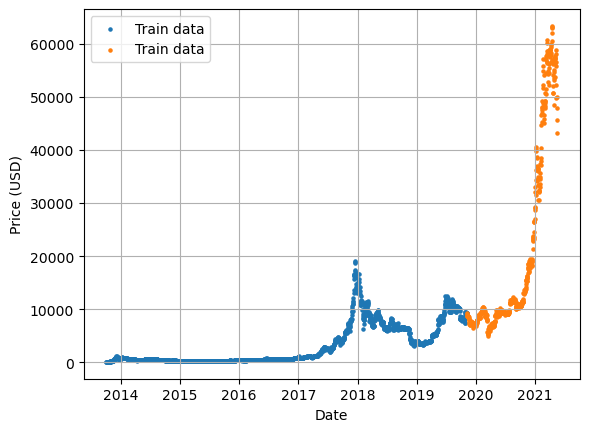

In [19]:
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Train data')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend(fontsize=10)

### Creating a plotting function

In [20]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None, s=5):
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=10)
    plt.grid(True)

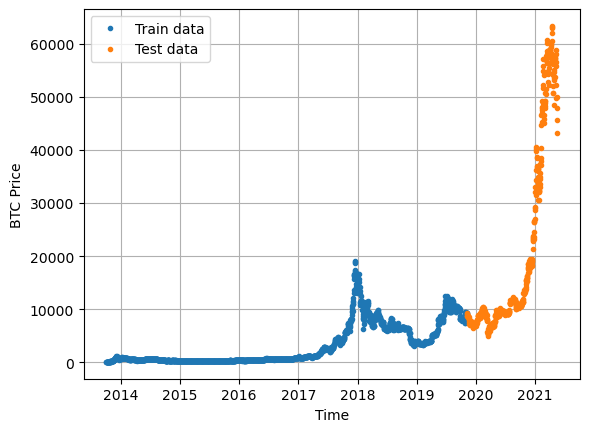

In [21]:
plot_time_series(X_train, y_train, label='Train data')
plot_time_series(X_test, y_test, label='Test data')

## Modelling Experiments

Important terminologies
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

Experiments list:
- 0 Naïve model (baseline)
- Dense model, horizon = 1, window = 7
- Same as 1, horizon = 1, window = 30
- Same as 1, horizon = 7, window = 30
- Conv1D
- LSTM
- Same as 1 (but with multivariate data)
- N-BEATs Algorithm
- Ensemble (multiple models optimized on different loss functions)
- Future prediction model (model to predict future values)
- Same as 1 (but with turkey 🦃 data introduced)

## Model 0: Naive forecast (baseline)

$$\hat{y}_{t} = y_{t-1}$$
> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [22]:
# create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

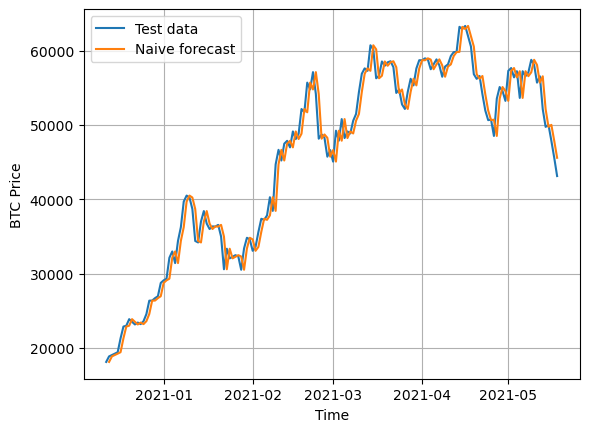

In [23]:
# plot forecast
# plot_time_series(X_train, y_train, label='Train data')
plot_time_series(X_test, y_test, start=400, format='-', label='Test data')
plot_time_series(X_test[1:], naive_forecast, start=400, format='-', label='Naive forecast')

In [24]:
import tensorflow as tf

In [25]:
# mase implementation
def mean_absolute_scaled_error(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

In [26]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [27]:
# function for evaluation metrics
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [28]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

## Windowing our dataset
```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [29]:
print(f"We want to use: {btc_prices[:7]} to predict this: {btc_prices[7]}")

We want to use: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] to predict this: 123.033


In [30]:
HORIZON = 1
WINDOW_SIZE = 7

In [31]:
# function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    return x[:, :-horizon], x[:, -horizon:]

In [32]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [33]:
import numpy as np

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    # create a window of specific window_size
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # create a 2D array of multiple window steps
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    # index on the target array
    windowed_array = x[window_indexes]
    # get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [35]:
full_windows, full_labels = make_windows(btc_prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [36]:
for i in range(3):
    print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [37]:
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


## Turning windows into training and test sets

In [38]:
# make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [39]:
# create train and test windows 
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

## Make a modelling checkpoint callback

In [40]:
import os

def create_model_checkpoint(model_name, save_path='model_experiments'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              monitor='val_loss',
                                              verbose=0,
                                              save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

In [41]:
import tensorflow as tf
from tensorflow.keras import layers

# set random seed
tf.random.set_seed(42)

# build the model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear'),
], name='model_1_dense')

In [42]:
# compile the model
model_1.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [43]:
# fit the model
model_1_history = model_1.fit(train_windows,
                              train_labels,
                              epochs=100,
                              verbose=1,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 109ms/step - loss: 1114.9302 - mae: 1114.9302 - mse: 5403500.5000 - val_loss: 1466.4539 - val_mae: 1466.4539 - val_mse: 5503376.5000
Epoch 2/100
18/18 [==============================] - 1s 72ms/step - loss: 285.3781 - mae: 285.3781 - mse: 313919.2812 - val_loss: 1190.9119 - val_mae: 1190.9119 - val_mse: 4108778.0000
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 204.7940 - mae: 204.7940 - mse: 210290.0000 - val_loss: 1236.7714 - val_mae: 1236.7714 - val_mse: 4164004.2500
Epoch 4/100
18/18 [==============================] - 1s 78ms/step - loss: 185.7487 - mae: 185.7487 - mse: 176813.1719 - val_loss: 1030.7042 - val_mae: 1030.7042 - val_mse: 3191552.5000
Epoch 5/100
18/18 [==============================] - 1s 81ms/step - loss: 169.3735 - mae: 169.3735 - mse: 151051.1875 - val_loss: 952.4402 - val_mae: 952.4402 - val_mse: 3001939.0000
Epoch 6/100
18/18 [==============================] - 1s 70ms/step - loss: 

In [44]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,665
Trainable params: 17,665
Non-trainable params: 0
_________________________________________________________________


In [45]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 590.0539 - mae: 590.0539 - mse: 1206184.2500


[590.0538940429688, 590.0538940429688, 1206184.25]

In [46]:
# load in saved best performing model_1
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 567.9340 - mae: 567.9340 - mse: 1163287.0000


[567.9340209960938, 567.9340209960938, 1163287.0]